Ce notebook a été entièrement réalisé par Mélanie Gomis.

# Réduction de dimension

In [1]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

os.chdir("../Données")

## Chargement des données

In [2]:
fichiers_npz = glob.glob('*.npz')

# Filtrer les fichiers contenant "COSMOS"
cosmos_files = [f for f in fichiers_npz if "COSMOS" in f]

# Charger les données des fichiers COSMOS
data_list = []
for fichier in cosmos_files:
    try:
        data = np.load(fichier, allow_pickle=True)
        data_list.append(data)
    except Exception as e:
        print(f"❌ Erreur en chargeant {fichier}: {e}")
        print(f"Total de fichiers COSMOS chargés: {len(data_list)}")

# Extraire toutes les valeurs de 'cube', 'info', et 'flag' depuis tous les fichiers
all_cubes = [data['cube'] for data in data_list if 'cube' in data]
all_infos = [data['info'] for data in data_list if 'info' in data]
all_flags = [data['flag'] for data in data_list if 'flag' in data]



## ACP

### Avec toutes les données

#### Code

In [3]:
# Sur les bandes
bandes = ['u', 'g', 'r', 'i', 'z', 'y', 'J', 'H']
X_list = []

for i, info in enumerate(all_infos):
    try:
        # Empile les bandes en colonnes → (n_objets, 8)
        bandes_data = [info[bande] for bande in bandes]  # liste de 8 vecteurs
        X_fichier = np.column_stack(bandes_data)  # shape = (n_objets, 8)
        X_list.append(X_fichier)
    except KeyError as e:
        print(f"❌ Bande manquante dans le fichier {i} : {e}")
    except Exception as e:
        print(f"⚠️ Erreur dans le fichier {i} : {e}")

# Concaténer tous les objets de tous les fichiers : shape = (total_objets, 8)
X = np.vstack(X_list)

# Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



In [4]:
# ACP 
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

In [5]:
# Variable supp  
Z_list = []

for i, info in enumerate(all_infos):
    # Vérifier si 'ZSPEC' est présent dans les champs
    Z_name = "ZSPEC"
    if Z_name not in info.dtype.names:
        Z_name = "ZPHOT"  # basculer sur ZPHOT si ZSPEC absent
    
    try:
        # Extraire la variable supp pour ce fichier
        Z_fichier = info[Z_name]  # tableau shape = (n_objets,)
        Z_list.append(Z_fichier)
    except KeyError:
        print(f"⚠️ {Z_name} absent dans fichier {i}, on remplace par NaN")
        Z_list.append(np.full(len(info), np.nan))

# Concaténer tous les fichiers en un seul vecteur
Z_color = np.concatenate(Z_list)



#### Visualisation

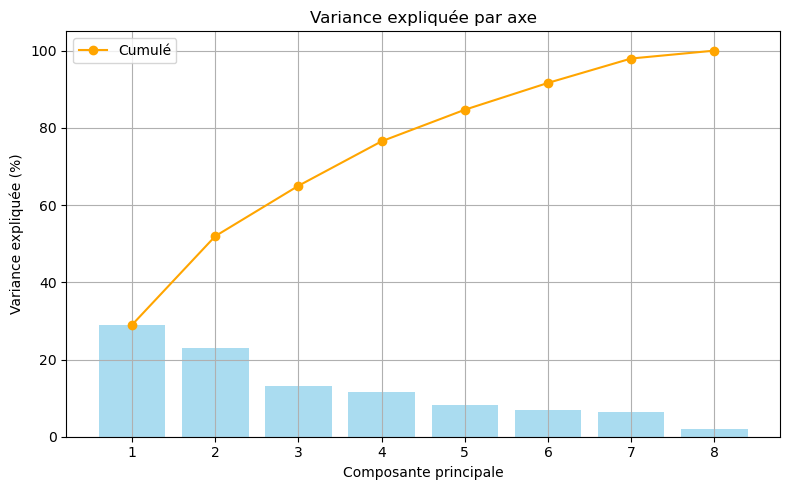

In [6]:
# 1. Diagramme de la variance expliquée
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), 
        pca.explained_variance_ratio_ * 100, alpha=0.7, color='skyblue')
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_) * 100, 
         marker='o', color='orange', label='Cumulé')
plt.xlabel('Composante principale')
plt.ylabel('Variance expliquée (%)')
plt.title('Variance expliquée par axe')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

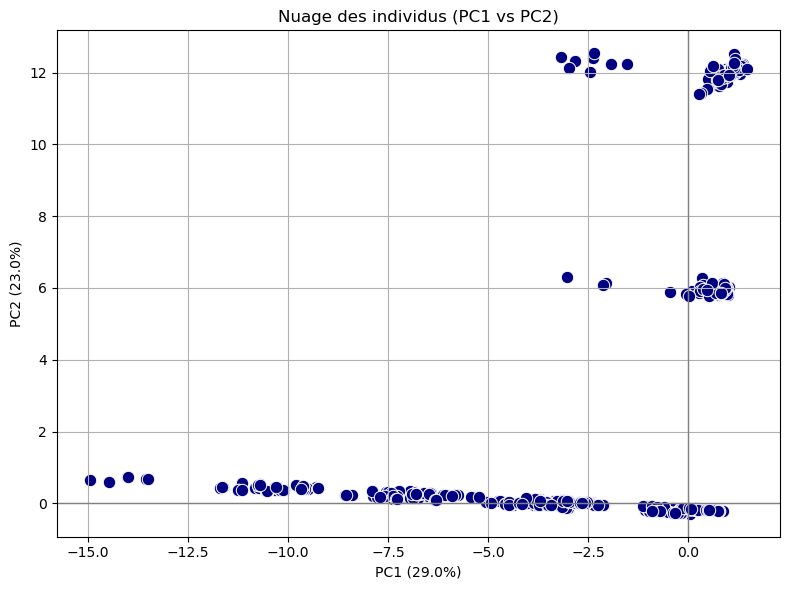

In [7]:
# Nuage des individus 
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], s=80, color='navy')
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("Nuage des individus (PC1 vs PC2)")
plt.grid(True)
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.tight_layout()
plt.show()


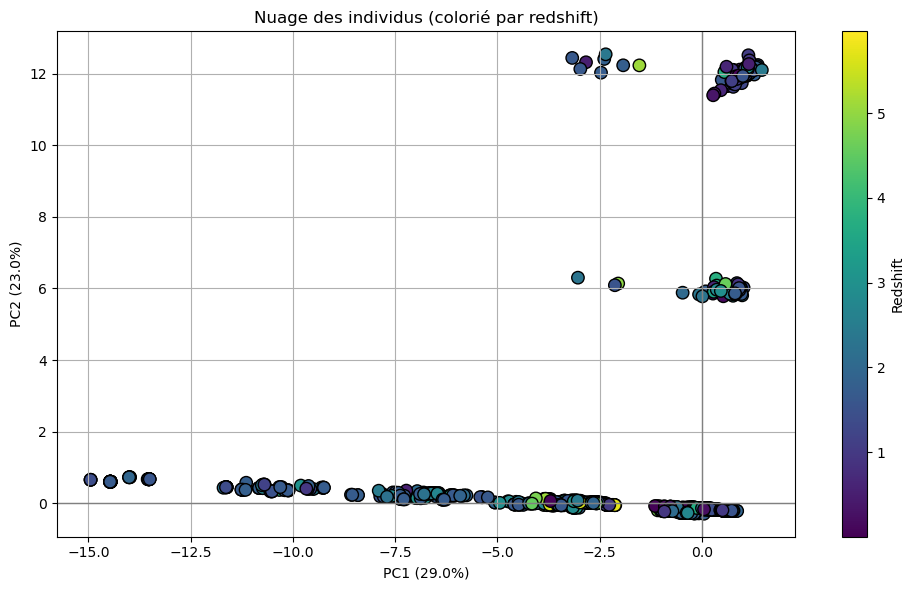

In [8]:
# Nuage des individus colorié 
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Z_color, cmap='viridis', s=80, edgecolor='k')
cbar = plt.colorbar(scatter)
cbar.set_label('Redshift')
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("Nuage des individus (colorié par redshift)")
plt.grid(True)
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.tight_layout()
plt.show()

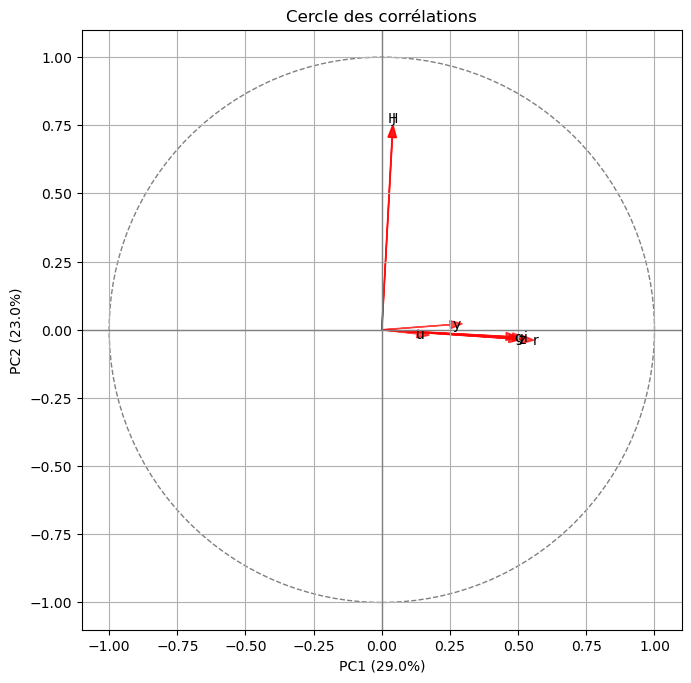

In [9]:
# 3. Cercle de corrélation 
loadings = pca.components_.T  # shape (variables, composantes)

# Cercle unité
plt.figure(figsize=(7, 7))
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
plt.gca().add_artist(circle)

# Tracer les vecteurs (corrélations)
for i, var in enumerate(bandes):
    x = loadings[i, 0]
    y = loadings[i, 1]
    plt.arrow(0, 0, x, y, color='red', alpha=0.7, head_width=0.03)
    plt.text(x*1.1, y*1.1, var, color='black', ha='center', va='center', fontsize=10)

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("Cercle des corrélations")
plt.grid()
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect('equal', 'box')
plt.tight_layout()
plt.show()

In [10]:
# 4. Contributions des variables aux composantes
contrib_PC1 = (loadings[:, 0]**2) * 100
contrib_PC2 = (loadings[:, 1]**2) * 100

contrib = np.vstack((contrib_PC1, contrib_PC2)).T
contrib_df = dict(zip(bandes, contrib))

print("Contributions des variables (en %):")
for i, band in enumerate(bandes):
    print(f"{band:>3} - PC1: {contrib_PC1[i]:5.2f}%  |  PC2: {contrib_PC2[i]:5.2f}%")


Contributions des variables (en %):
  u - PC1:  1.67%  |  PC2:  0.02%
  g - PC1: 20.73%  |  PC2:  0.06%
  r - PC1: 26.35%  |  PC2:  0.12%
  i - PC1: 22.95%  |  PC2:  0.07%
  z - PC1: 21.73%  |  PC2:  0.10%
  y - PC1:  6.27%  |  PC2:  0.04%
  J - PC1:  0.15%  |  PC2: 49.78%
  H - PC1:  0.14%  |  PC2: 49.81%


### Sans les données abérrantes

#### Code

In [11]:
# Sur les bandes
bandes = ['u', 'g', 'r', 'i', 'z', 'y', 'J', 'H']
X_list = []

for i, info in enumerate(all_infos):
    try:
        # Empile les bandes en colonnes → (n_objets, 8)
        bandes_data = [info[bande] for bande in bandes]  # liste de 8 vecteurs
        X_fichier = np.column_stack(bandes_data)  # shape = (n_objets, 8)

        # Filtrer : on ne garde que les lignes où toutes les valeurs sont ≥ 0
        mask_valide = np.all(X_fichier >= 0, axis=1)
        X_fichier_filtré = X_fichier[mask_valide]

        X_list.append(X_fichier_filtré)
    except KeyError as e:
        print(f"❌ Bande manquante dans le fichier {i} : {e}")
    except Exception as e:
        print(f"⚠️ Erreur dans le fichier {i} : {e}")

# Concaténer tous les objets de tous les fichiers : shape = (total_objets, 8)
X = np.vstack(X_list)

# Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



In [12]:
# ACP 
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

In [13]:
# Variable supp  
Z_list = []

for i, info in enumerate(all_infos):
    Z_name = "ZSPEC" if "ZSPEC" in info.dtype.names else "ZPHOT"
    
    try:
        # Empile les bandes en colonnes → shape = (n_objets, 8)
        bandes_data = [info[bande] for bande in bandes]
        X_fichier = np.column_stack(bandes_data)

        # Filtrer : on ne garde que les lignes où toutes les valeurs sont ≥ 0
        mask_valide = np.all(X_fichier >= 0, axis=1)
        X_fichier_filtré = X_fichier[mask_valide]

        # Extraire Z (ZSPEC ou ZPHOT)
        Z_name = "ZSPEC" if "ZSPEC" in info.dtype.names else "ZPHOT"
        if Z_name not in info.dtype.names:
            raise KeyError(f"{Z_name} manquant")

        Z_fichier = info[Z_name]
        Z_fichier_filtré = Z_fichier[mask_valide]

        # Append les données filtrées
        X_list.append(X_fichier_filtré)
        Z_list.append(Z_fichier_filtré)
    except KeyError:
        print(f"⚠️ {Z_name} absent dans fichier {i}, on remplace par NaN")
        Z_list.append(np.full(len(info), np.nan))

# Concaténer tous les fichiers en un seul vecteur
Z_color = np.concatenate(Z_list)

#### Visualisation

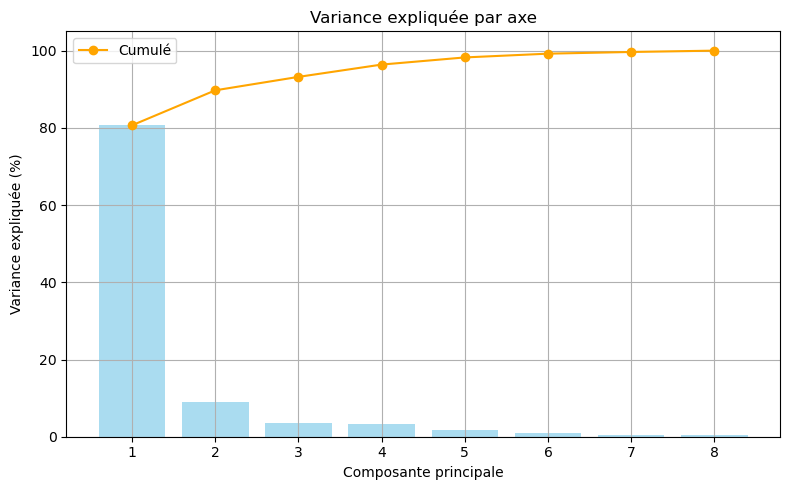

In [14]:
# 1. Diagramme de la variance expliquée
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), 
        pca.explained_variance_ratio_ * 100, alpha=0.7, color='skyblue')
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_) * 100, 
         marker='o', color='orange', label='Cumulé')
plt.xlabel('Composante principale')
plt.ylabel('Variance expliquée (%)')
plt.title('Variance expliquée par axe')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

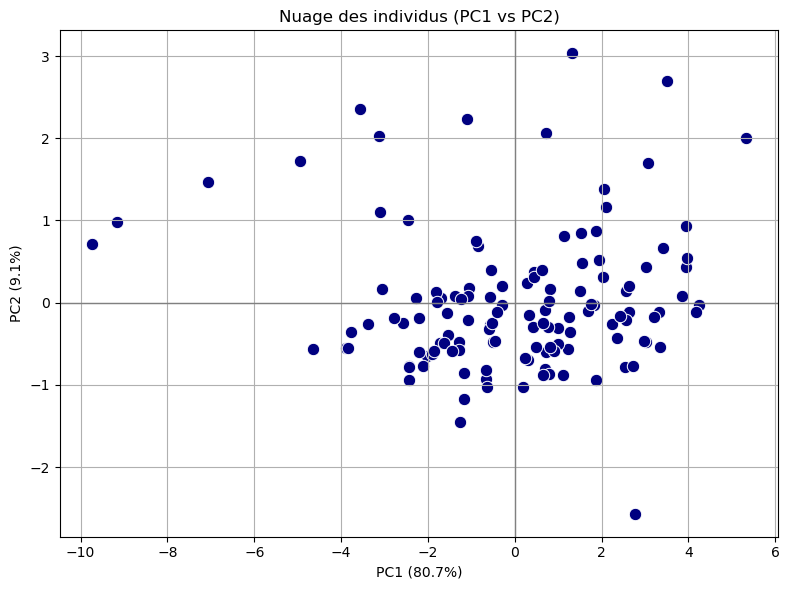

In [15]:
# Nuage des individus 
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], s=80, color='navy')
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("Nuage des individus (PC1 vs PC2)")
plt.grid(True)
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.tight_layout()
plt.show()

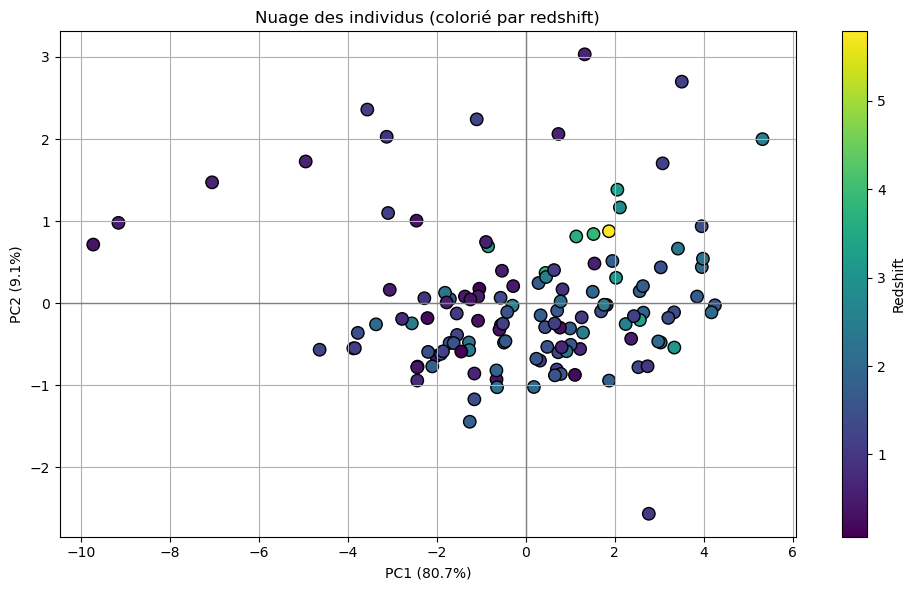

In [16]:
# Nuage des individus colorié 
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Z_color, cmap='viridis', s=80, edgecolor='k')
cbar = plt.colorbar(scatter)
cbar.set_label('Redshift')
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("Nuage des individus (colorié par redshift)")
plt.grid(True)
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.tight_layout()
plt.show()

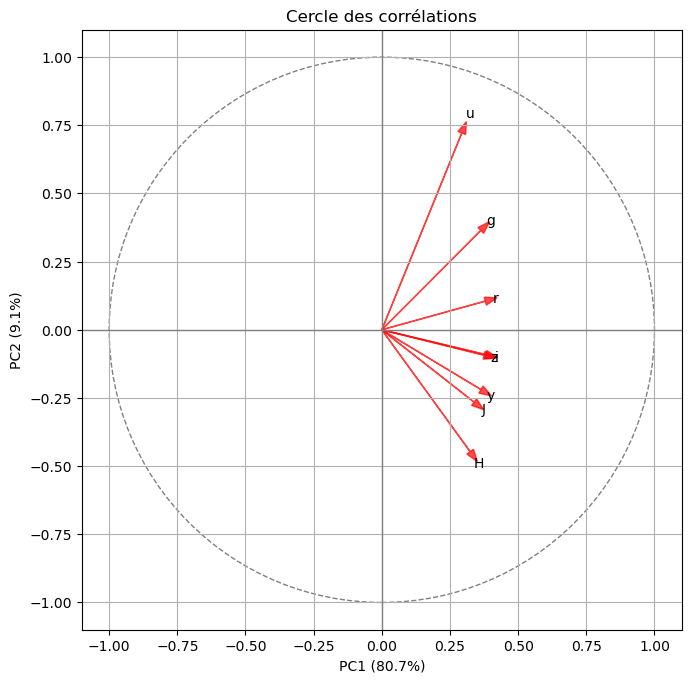

In [17]:
# 3. Cercle de corrélation 
loadings = pca.components_.T  # shape (variables, composantes)

# Cercle unité
plt.figure(figsize=(7, 7))
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
plt.gca().add_artist(circle)

# Tracer les vecteurs (corrélations)
for i, var in enumerate(bandes):
    x = loadings[i, 0]
    y = loadings[i, 1]
    plt.arrow(0, 0, x, y, color='red', alpha=0.7, head_width=0.03)
    plt.text(x*1.1, y*1.1, var, color='black', ha='center', va='center', fontsize=10)

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("Cercle des corrélations")
plt.grid()
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect('equal', 'box')
plt.tight_layout()
plt.show()

In [18]:
# 4. Contributions des variables aux composantes
contrib_PC1 = (loadings[:, 0]**2) * 100
contrib_PC2 = (loadings[:, 1]**2) * 100

contrib = np.vstack((contrib_PC1, contrib_PC2)).T
contrib_df = dict(zip(bandes, contrib))

print("Contributions des variables (en %):")
for i, band in enumerate(bandes):
    print(f"{band:>3} - PC1: {contrib_PC1[i]:5.2f}%  |  PC2: {contrib_PC2[i]:5.2f}%")

Contributions des variables (en %):
  u - PC1:  8.60%  |  PC2: 52.09%
  g - PC1: 13.18%  |  PC2: 13.29%
  r - PC1: 14.40%  |  PC2:  1.11%
  i - PC1: 14.55%  |  PC2:  0.83%
  z - PC1: 14.08%  |  PC2:  0.87%
  y - PC1: 13.23%  |  PC2:  4.81%
  J - PC1: 11.45%  |  PC2:  7.04%
  H - PC1: 10.50%  |  PC2: 19.97%
